Выбор модели определения биологического возраста

In [1]:
from llamba_library.bioage_model import BioAgeModel
from txai_omics_3.models.tabular.widedeep.ft_transformer \
    import WDFTTransformerModel, FN_CHECKPOINT, TRAIN_DATA_PATH

dataset_path = TRAIN_DATA_PATH
fn_model = FN_CHECKPOINT
model = WDFTTransformerModel.load_from_checkpoint(fn_model)
bioage_model = BioAgeModel(model=model)

h:\Lobachevsky\llamba_library\venv\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.1.4
h:\Lobachevsky\llamba_library\venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


Определение SHAP-значений

In [2]:
import pandas as pd
import torch
import numpy as np
feats = [
    'CXCL9',
    'CCL22',
    'IL6',
    'PDGFB',
    'CD40LG',
    'IL27',
    'VEGFA',
    'CSF1',
    'PDGFA',
    'CXCL10'
]

my_data = {'CXCL9': 2599.629474, 
           'CCL22': 820.306524, 
           'IL6': 0.846377, 
           'PDGFB': 13400.666359, 
           'CD40LG': 1853.847406, 
           'IL27': 1128.886982,
           'VEGFA': 153.574220,
           'CSF1': 239.627236,
           'PDGFA': 1005.844290,
           'CXCL10': 228.229829,
           'Age': 90.454972 }

data = pd.DataFrame(my_data, index=[0])

train_data = pd.read_excel(TRAIN_DATA_PATH)
train_data = train_data[train_data['Split'] == 'trn_val'].copy()
train_data = train_data.loc[:, feats + ['Age']]

def predict_func(x):
    batch = {
        'all': torch.from_numpy(np.float32(x)),
        'continuous': torch.from_numpy(np.float32(x))
    }
    return bioage_model.model(batch).cpu().detach().numpy()

n = len(feats) # количество признаков с наибольшим вкладом
top_shap = bioage_model.get_top_shap(n, data, feats, train_data, predict_func)
data['bio_age'] = bioage_model.inference(data=data.drop(['Age'], axis=1), device='cpu')

.values =
array([[-10.05299553,  -1.70880471,  -4.85424132,   0.89499197,
          7.2451361 ,   0.73839988,   0.06021076,   0.64539789,
          2.18744784,  -0.8615773 ]])

.base_values =
array([[84.72380349]])

.data =
array([[2.59962947e+03, 8.20306524e+02, 8.46377000e-01, 1.34006664e+04,
        1.85384741e+03, 1.12888698e+03, 1.53574220e+02, 2.39627236e+02,
        1.00584429e+03, 2.28229829e+02]])


In [3]:
# Отсортированные в порядке увеличения вклада
print("SHAP values")
print(top_shap['values'])
print("Sorted data values")
print(top_shap['data'])
print("Sorted features")
print(top_shap['feats']) 

SHAP values
[0.0602107622608627, 0.6453978923536997, 0.7383998799768312, -0.8615773005515169, 0.8949919730239771, -1.708804709866922, 2.18744784053068, -4.854241320213179, 7.245136099868681, -10.052995532491936]
Sorted data values
[153.57422, 239.627236, 1128.886982, 228.229829, 13400.666359, 820.306524, 1005.84429, 0.846377, 1853.847406, 2599.629474]
Sorted features
['VEGFA', 'CSF1', 'IL27', 'CXCL10', 'PDGFB', 'CCL22', 'PDGFA', 'IL6', 'CD40LG', 'CXCL9']


Визуализация вклада отдельных признаков в оценку биологического возраста

h:\Lobachevsky\llamba_library\venv\Lib\site-packages\shap\plots\_waterfall.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_values = float(shap_values.base_values)


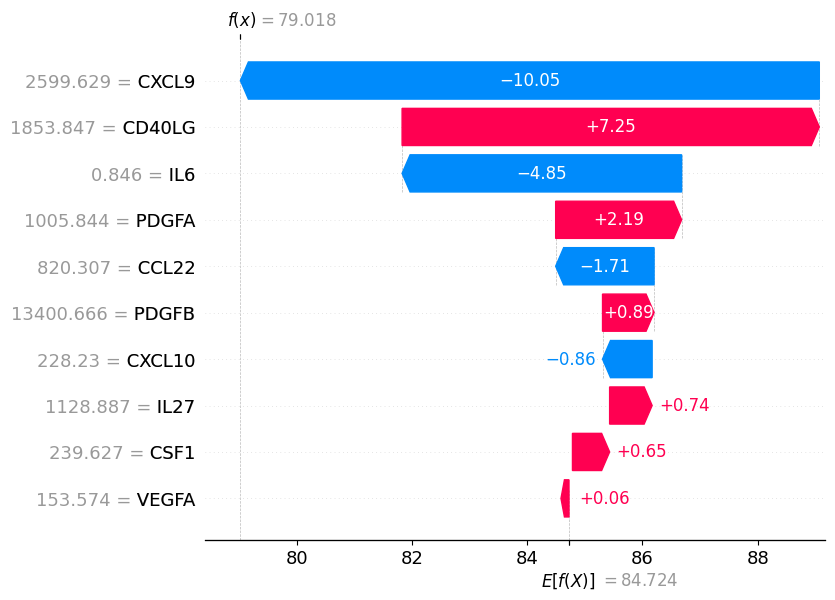

In [5]:
import llamba_library.plots as bplt
bplt.shap_plot(shap_dict=top_shap)